In [1]:
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from utils import numpy, DataModule, Module, Trainer

2023-03-26 18:59:27.318256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Fashion-MNIST Dataset 

In [2]:
class FashionMNIST(DataModule):
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        self.train, self.val = tf.keras.datasets.fashion_mnist.load_data()

    def text_labels(self, indices):
        """Return text labels."""
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        data = self.train if train else self.val

        def process(X, y): return (tf.expand_dims(
            X, axis=3) / 255, tf.cast(y, dtype=tf.int32))

        def resize_fn(X, y): return (
            tf.image.resize_with_pad(X, *self.resize), y)
        shuffle_buf = len(data[0]) if train else 1
        return tf.data.Dataset.from_tensor_slices(process(*data))\
                              .batch(self.batch_size)\
                              .map(resize_fn)\
                              .shuffle(shuffle_buf)

    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        show_images(tf.squeeze(X), nrows, ncols, titles=labels)

In [3]:
data = FashionMNIST()
X, y = next(iter(data.train_dataloader()))
X.shape, y.shape

2023-03-26 19:00:33.076409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(TensorShape([64, 28, 28, 1]), TensorShape([64]))

In [4]:
# time to read the images.
tic = time.time()
for X, y in data.train_dataloader():
    continue
f'{time.time() - tic:.2f} sec'

'0.78 sec'

In [5]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.
    Defined in :numref:`sec_utils`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = numpy(img)
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

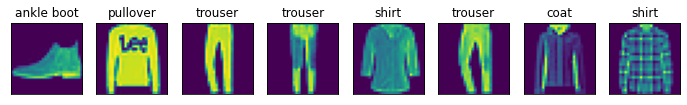

In [6]:
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

# The Base Classification Model

In [7]:
class Classifier(Module):
    def validation_step(self, batch):
        y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # use a stochastic gradient descent optimizer, operating on minibatches
        return tf.keras.optimizers.SGD(self.lr)

    def accuracy(self, y_hat, y, averaged=True):
        y_hat = tf.reshape(y_hat, (-1, y_hat.shape[-1]))
        preds = tf.cast(tf.argmax(y_hat, axis=1), y.dtype)
        compare = tf.cast(preds == tf.reshape(y, -1), tf.float32)
        return tf.reduce_mean(compare) if averaged else compare

# Implement Softmax Regression from Scratch

## The Softmax

In [8]:
# sum over all elements (by default) or only over elements in the same axis.
X = tf.constant([[1.0, 2.0, 3.0],
                 [4.0, 5.0, 6.0]])
tf.reduce_sum(X, 0, keepdims=True), tf.reduce_sum(X, 1, keepdims=True)

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 6.],
        [15.]], dtype=float32)>)

In [9]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition


X = tf.random.uniform((2, 5))
X_prob = softmax(X)
X_prob, tf.reduce_sum(X_prob, 1)

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.20241022, 0.25598204, 0.1423115 , 0.26304427, 0.13625188],
        [0.16458385, 0.276843  , 0.2791237 , 0.13717286, 0.14227657]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9999999, 1.       ], dtype=float32)>)

## The Model

In [10]:
class SoftmaxRegression(Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = tf.random.normal((num_inputs, num_outputs), 0, sigma)
        self.b = tf.zeros(num_outputs)
        self.W = tf.Variable(self.W)
        self.b = tf.Variable(self.b)

    def forward(self, X):
        # flatten each 28x28 pixel image in the batch into a vector
        X = tf.reshape(X, (-1, self.W.shape[0]))
        return softmax(tf.matmul(X, self.W) + self.b)

    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)

## The Cross-Entropy Loss

Cross-entropy takes the negative log-likelihood of the predicted probability assigned to the true label. 

$$l(\mathbf{y}, \mathbf{\hat{y}}) = \sum_{j=1}^q y_j \log \hat{y}_j$$
The one-hot encoding in $\mathbf{y}$ allows us to select the matching terms in $\mathbf{\hat{y}}$.

Create sample data y_hat with 2 examples of predicted probabilities over 3 classes and their corresponding labels y. The correct labels are 0 and 2 respectively (i.e., the first and third class). Using y as the indices of the probabilities in y_hat, we can pick out terms efficiently.

In [11]:
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0, 2])
tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

In [12]:
def cross_entropy(y_hat, y):
    # average over the logarithms of the selected probabilities.
    return -tf.reduce_mean(tf.math.log(tf.boolean_mask(y_hat,
                                                       tf.one_hot(y, depth=y_hat.shape[-1]))))

In [13]:
cross_entropy(y_hat, y)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4978662>

## Training 

In [17]:
data = FashionMNIST(batch_size=256)

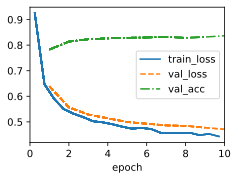

In [14]:
model = SoftmaxRegression(num_inputs=28*28, num_outputs=10, lr=0.1)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)

## Prediction

In [42]:
X, y = next(iter(data.val_dataloader()))
preds = tf.argmax(model(X), axis=1)
preds.shape

TensorShape([256])

In [43]:
wrong = tf.cast(preds, y.dtype) != y

In [47]:
X, y, preds = X[wrong], y[wrong], preds[wrong]

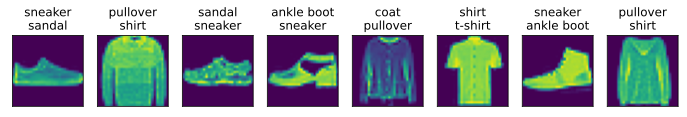

In [50]:
labels = [a+'\n'+b for a,
          b in zip(data.text_labels(y), data.text_labels(preds))]
data.visualize([X,y], labels=labels)

# Implement Softmax Regression with Tensorflow

In [59]:
class SoftmaxRegressionKeras(Classifier):
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential()
        # use a Flatten layer to convert the 4th order tensor X 
        # by keeping the dimension along the first axis unchanged.
        self.net.add(tf.keras.layers.Flatten())
        self.net.add(tf.keras.layers.Dense(num_outputs))
        
    def forward(self, X):
        return self.net(X)
    
    def loss(self,y_hat, y, averaged=True):
        y_hat = tf.reshape(y_hat, (-1, y_hat.shape[-1]))
        y = tf.reshape(y, (-1,))
        # from_logits: Whether `y_pred` is expected to be a logits tensor. 
        # instead of passing softmax probabilities into our new loss function, 
        # we just pass the logits and compute the softmax and its log all at once inside the cross-entropy loss function
        fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        return fn(y, y_hat)

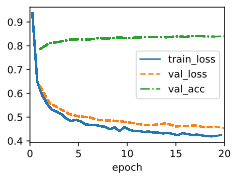

In [60]:
# use Fashion-MNIST images, flattened to 784-dimensional feature vectors.
data = FashionMNIST(batch_size=256)
model = SoftmaxRegressionKeras(num_outputs=10, lr=0.1)
trainer = Trainer(max_epochs=20)
trainer.fit(model, data)

# Generalization

 Test set evaluations provide an unbiased estimate of the true error and converge at the desired $O(1\ \sqrt{n})$ rate as the test set grows.
 
  Once the same test set is used to evaluate multiple models, controlling for **false discovery** can be difficult. This can cause huge problems in theory. 
  
  In practice, the significance of the problem depends on the size of the holdout sets in question and whether they are merely being used to choose hyperparameters or if they are leaking information more directly. Nevertheless, it is *good practice to curate real test sets (or multiple) and to be as conservative as possible about how often they are used.*
  
   Vladimir Vapnik and Alexey Chernovenkis introduced the VC dimension, presenting uniform convergence results that hold for all models in a VC class. The training errors for all models in the class are (simultaneously) guaranteed to be close to their true errors, and guaranteed to grow closer at $O(1\ \sqrt{n})$  rates.
 
   Deep neural networks often have millions of parameters (or more), and can easily assign random labels to large collections of points. Nevertheless, they generalize well on practical problems and, surprisingly, they often generalize better, when they are larger and deeper, despite incurring larger VC dimensions.

# Environment and Distribution Shift

## Types of Distribution Shift
1. **Covariate Shift**: Assume that while the distribution of inputs may change over time, the labeling function, i.e., the conditional distribution $P(y|\mathbf{x})$ does not change. 
2. **Label Shift**: Assume that the label marginal $P(y)$ can change but the class-conditional distribution $P(\mathbf{x}|y)$ remains fixed across domains.
3. **Concept Shift**: When the very definitions of labels can change.

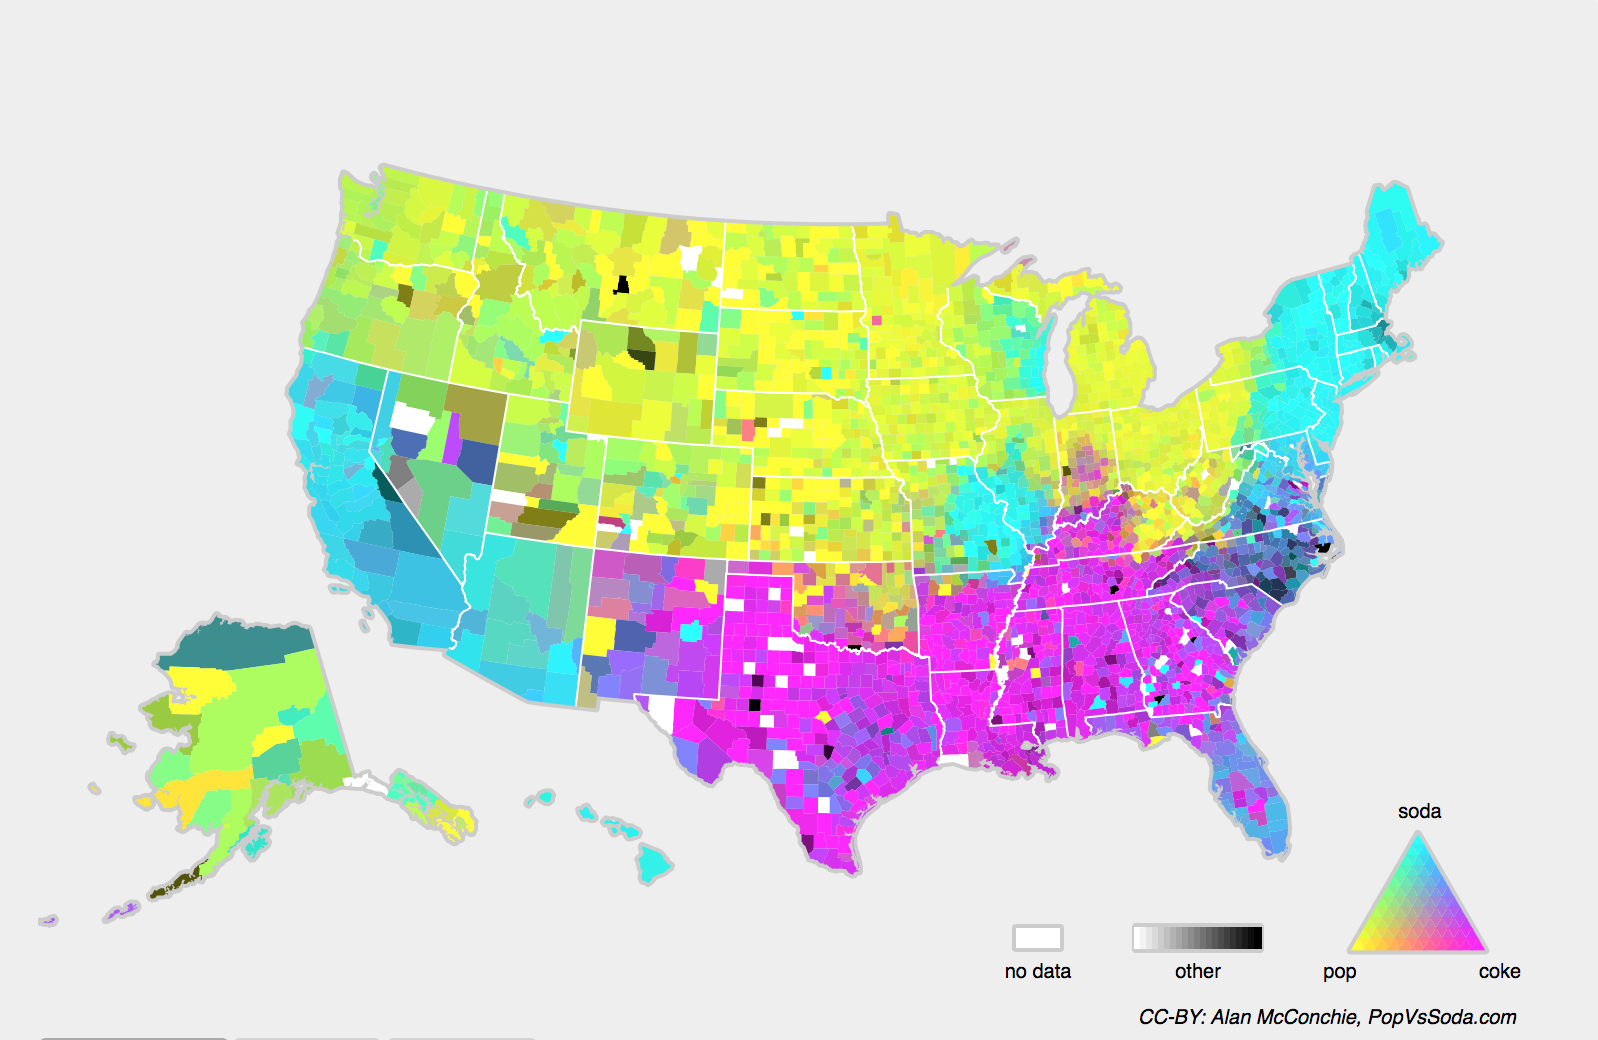

# Tensorflow knowledge

1. `tf.expand_dims(input, axis, name=None)`:

Returns a tensor with a length 1 axis inserted at index `axis`.

2. `tf.cast(x, dtype, name=None)`

Casts a tensor to a new type.

3. 
```
tf.image.resize_with_pad(
    image,
    target_height,
    target_width,
    method='bilinear',
    antialias=False,
)

    Resizes and pads an image to a target width and height.

    Resizes an image to a target width and height by keeping
    the aspect ratio the same without distortion. If the target
    dimensions don't match the image dimensions, the image
    is resized and then padded with zeroes to match requested
    dimensions.
    
    Args:
      image: 4-D Tensor of shape `[batch, height, width, channels]` or 3-D Tensor
        of shape `[height, width, channels]`.
      target_height: Target height.
      target_width: Target width.
      method: Method to use for resizing image. See `image.resize()`
      antialias: Whether to use anti-aliasing when resizing. See 'image.resize()'.

```

4. `tf.Dataset.shuffle(buffer_size, seed=None, reshuffle_each_iteration=None, name=None)`

This dataset fills a buffer with `buffer_size` elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.



5. `tf.data.Dataset.from_tensor_slices(tensors, name=None)`

Creates a `Dataset` whose elements are slices of the given tensors.

The given tensors are sliced along their first dimension. This operation
preserves the structure of the input tensors, removing the first dimension
of each tensor and using it as the dataset dimension. All input tensors
must have the same size in their first dimensions.
```
>>> # Slicing a 1D tensor produces scalar tensor elements.
>>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
>>> list(dataset.as_numpy_iterator())
[1, 2, 3] 
```

6. `tf.keras.layers.Flatten(data_format=None, **kwargs)`

Flattens the input. Does not affect the batch size.

7. `tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    ignore_class=None,
    reduction='auto',
    name='sparse_categorical_crossentropy',
)`

Computes the crossentropy loss between the labels and predictions.

Use this crossentropy loss function when there are two or more label
classes.  We expect labels to be provided as integers. If you want to
provide labels using `one-hot` representation, please use
`CategoricalCrossentropy` loss.  There should be `# classes` floating point
values per feature for `y_pred` and a single floating point value per
feature for `y_true`.

In the snippet below, there is a single floating point value per example for
`y_true` and `# classes` floating pointing values per example for `y_pred`.
The shape of `y_true` is `[batch_size]` and the shape of `y_pred` is
`[batch_size, num_classes]`.

Standalone usage:
```
>>> y_true = [1, 2]
>>> y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
>>> # Using 'auto'/'sum_over_batch_size' reduction type.
>>> scce = tf.keras.losses.SparseCategoricalCrossentropy()
>>> scce(y_true, y_pred).numpy()
1.177
```